In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel(r'C:\Users\komal\Downloads\1(a)\database.xlsx')

In [3]:
df.head()

,# compound id (and file prefix),SMILES,IUPAC,Expt,experimental uncertainty (kcal/mol),Mobley group calculated value (GAFF) (kcal/mol),calculated uncertainty (kcal/mol),experimental reference (original or paper this value was taken from),calculated reference,text notes.
0,mobley_1017962,CCCCCC(=O)OC,methyl hexanoate,-2.49,0.6,-3.30,0.03,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availa...
1,mobley_1019269,CCCCO,butan-1-ol,-4.72,0.6,-3.23,0.03,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availa...
2,mobley_1034539,c1cc(c(cc1c2cc(c(c(c2Cl)Cl)Cl)Cl)Cl)Cl,"1,2,3,4-tetrachloro-5-(3,4-dichlorophenyl)ben...",-3.04,0.1,-1.08,0.04,10.1007/s10822-012-9568-8,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availa...
3,mobley_1036761,C1CCC(CC1)N,cyclohexanamine,-4.59,0.6,-3.95,0.03,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availa...
4,mobley_1046331,c1ccc(cc1)OC=O,phenyl formate,-3.82,0.6,-5.44,0.03,"J. Peter Guthrie, unpublished data, as provid...",10.1021/acs.jced.7b00104,Experimental uncertainty not presently availa...


In [4]:
smiles = df['SMILES'].tolist()
solvents = df['IUPAC'].tolist()
energies = df['Expt'].tolist()

# generating morgan fingerprints
mols = [Chem.MolFromSmiles(smi)for smi in smiles]
fps = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in mols]
fingerprints = np.array([np.array(fp) for fp in fps])

# 3a

With standardization

In [5]:
scaler = StandardScaler()
energies_std = scaler.fit_transform(np.array(energies).reshape(-1,1))

In [6]:
# doing 75:25 split for our training and testing 
X_train, X_test, y_train, y_test = train_test_split(fingerprints, energies_std, test_size=0.25, random_state=42)

In [7]:
# Define a PyTorch dataset for the data
class FreeSolvDataset(Dataset):
    def __init__(self, fingerprints, energies):
        self.fingerprints = torch.tensor(fingerprints).float()
        self.energies = torch.tensor(energies).float()
        
    def __len__(self):
        return len(self.fingerprints)
    
    def __getitem__(self, idx):
        return self.fingerprints[idx], self.energies[idx]
    
# Define a PyTorch model with ReLU as activation function
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# Train the PyTorch model
n_epochs = 100
train_dataset = FreeSolvDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

model = Net(input_size = 2048, hidden_size = 128, output_size = 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [9]:
train_loss_list = []
y_pred_train_list = []
for epoch in range(n_epochs):
    train_loss = 0
    epoch_size = 0
    for fingerprints,energies in train_loader:
        optimizer.zero_grad()
        outputs = model(fingerprints)
        y_pred_train_list.append(outputs)
        loss = criterion(outputs, energies)
        train_loss += loss.item()*len(energies)
        epoch_size += len(energies)
        loss.backward()
        optimizer.step()
    train_loss /= epoch_size
    train_loss_list.append(train_loss)
    if (epoch+1)%10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, train_loss))

Epoch [10/100], Loss: 0.0409
Epoch [20/100], Loss: 0.0125
Epoch [30/100], Loss: 0.0164
Epoch [40/100], Loss: 0.0030
Epoch [50/100], Loss: 0.0165
Epoch [60/100], Loss: 0.0015
Epoch [70/100], Loss: 0.0007
Epoch [80/100], Loss: 0.0019
Epoch [90/100], Loss: 0.0041
Epoch [100/100], Loss: 0.0179


Text(0, 0.5, 'Train Loss')

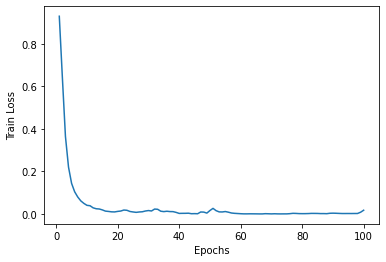

In [10]:
plt.figure()
plt.plot(range(1, n_epochs+1), train_loss_list, label = 'Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')

In [11]:
# Evaluate PyTorch model on test set
test_dataset = FreeSolvDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

with torch.no_grad():
    model.eval()
    test_loss = 0
    for fingerprints,energies in test_loader:
        outputs = model(fingerprints)
        test_loss += criterion(outputs, energies).item()*len(energies)
    test_loss /= len(test_dataset)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.2409


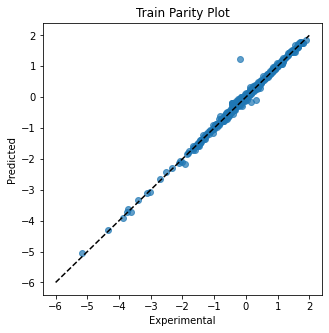

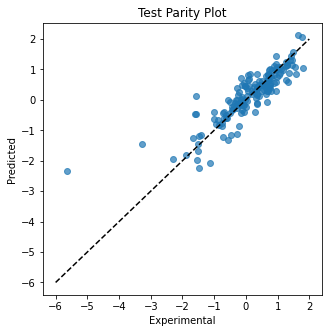

In [12]:
# Predict solvation free energies for train
train_pred = model(torch.Tensor(X_train)).detach().numpy()
# Predict solvation free energies for test
test_pred = model(torch.Tensor(X_test)).detach().numpy()

# Plot parity plot for training set
plt.figure(figsize=(5,5))
plt.scatter(y_train, train_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Train Parity Plot')
plt.show()

# Plot parity plot for testing set
plt.figure(figsize=(5,5))
plt.scatter(y_test, test_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Test Parity Plot')
plt.show()

In [13]:
# train data metrics
train_mse = sklearn.metrics.mean_squared_error(y_train, train_pred)
train_mae = sklearn.metrics.mean_absolute_error(y_train, train_pred)
train_r2 = sklearn.metrics.r2_score(y_train, train_pred)
print(f'Train MSE: {train_mse} Train MAE: {train_mae} Train R2 Score: {train_r2}')

# test data metrics
test_mse = sklearn.metrics.mean_squared_error(y_test, test_pred)
test_mae = sklearn.metrics.mean_absolute_error(y_test, test_pred)
test_r2 = sklearn.metrics.r2_score(y_test, test_pred)
print(f'Testn MSE: {test_mse} Test MAE: {test_mae} Test R2 Score: {test_r2}')

Train MSE: 0.008404786844188111 Train MAE: 0.0486704898651445 Train R2 Score: 0.991660626929127
Testn MSE: 0.2408568832038636 Test MAE: 0.3165162311932363 Test R2 Score: 0.7488223117452043


Without standarization

In [14]:
smiles = df['SMILES'].tolist()
solvents = df['IUPAC'].tolist()
energies = df['Expt'].tolist()

# generating morgan fingerprints
mols = [Chem.MolFromSmiles(smi)for smi in smiles]
fps = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in mols]
fingerprints = np.array([np.array(fp) for fp in fps])

In [15]:
# doing 75:25 split for our training and testing 
X_train, X_test, y_train, y_test = train_test_split(fingerprints, energies, test_size=0.25, random_state=42)

In [16]:
# Train the PyTorch model
n_epochs = 100
train_dataset = FreeSolvDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

model = Net(input_size = 2048, hidden_size = 128, output_size = 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [19]:
train_loss_list = []
y_pred_train_list = []
for epoch in range(n_epochs):
    train_loss = 0
    epoch_size = 0
    for fingerprints,energies in train_loader:
        optimizer.zero_grad()
        outputs = model(fingerprints)
        y_pred_train_list.append(outputs)
        loss = criterion(outputs, energies)
        train_loss += loss.item()*len(energies)
        epoch_size += len(energies)
        loss.backward()
        optimizer.step()
    train_loss /= epoch_size
    train_loss_list.append(train_loss)
    if (epoch+1)%10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, train_loss))

Epoch [10/100], Loss: 15.1223
Epoch [20/100], Loss: 15.0754
Epoch [30/100], Loss: 15.0909
Epoch [40/100], Loss: 15.1041
Epoch [50/100], Loss: 15.0323
Epoch [60/100], Loss: 15.1123
Epoch [70/100], Loss: 15.0998
Epoch [80/100], Loss: 15.0695
Epoch [90/100], Loss: 15.1053
Epoch [100/100], Loss: 15.0652


Text(0, 0.5, 'Train Loss')

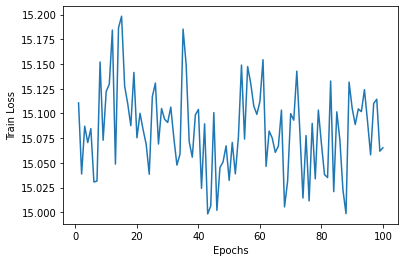

In [20]:
plt.figure()
plt.plot(range(1, n_epochs+1), train_loss_list, label = 'Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')

In [21]:
# Evaluate PyTorch model on test set
test_dataset = FreeSolvDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

with torch.no_grad():
    model.eval()
    test_loss = 0
    for fingerprints,energies in test_loader:
        outputs = model(fingerprints)
        test_loss += criterion(outputs, energies).item()*len(energies)
    test_loss /= len(test_dataset)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 15.2373


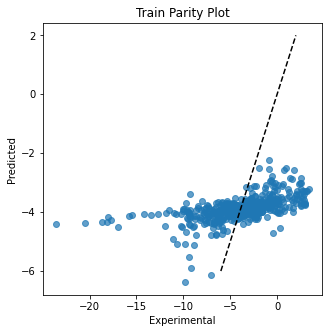

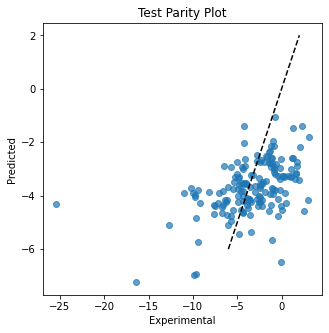

In [22]:
# Predict solvation free energies for train
train_pred = model(torch.Tensor(X_train)).detach().numpy()
# Predict solvation free energies for test
test_pred = model(torch.Tensor(X_test)).detach().numpy()

# Plot parity plot for training set
plt.figure(figsize=(5,5))
plt.scatter(y_train, train_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Train Parity Plot')
plt.show()

# Plot parity plot for testing set
plt.figure(figsize=(5,5))
plt.scatter(y_test, test_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Test Parity Plot')
plt.show()

In [23]:
# train data metrics
train_mse = sklearn.metrics.mean_squared_error(y_train, train_pred)
train_mae = sklearn.metrics.mean_absolute_error(y_train, train_pred)
train_r2 = sklearn.metrics.r2_score(y_train, train_pred)
print(f'Train MSE: {train_mse} Train MAE: {train_mae} Train R2 Score: {train_r2}')

# test data metrics
test_mse = sklearn.metrics.mean_squared_error(y_test, test_pred)
test_mae = sklearn.metrics.mean_absolute_error(y_test, test_pred)
test_r2 = sklearn.metrics.r2_score(y_test, test_pred)
print(f'Test MSE: {test_mse} Test MAE: {test_mae} Test R2 Score: {test_r2}')

Train MSE: 13.192515743555647 Train MAE: 2.6366930523632472 Train R2 Score: 0.11451380019204305
Test MSE: 11.759380175984196 Test MAE: 2.515177870092925 Test R2 Score: 0.17042834434403642


# 3b 

Using sigmoid as activation function

In [24]:
# Define a PyTorch model with sigmoid as activation function
class Net_sigmoid(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.nn.functional.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
# Train the PyTorch model
n_epochs = 100
train_dataset = FreeSolvDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

model = Net_sigmoid(input_size = 2048, hidden_size = 128, output_size = 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [27]:
train_loss_list = []
y_pred_train_list = []
for epoch in range(n_epochs):
    train_loss = 0
    epoch_size = 0
    for fingerprints,energies in train_loader:
        optimizer.zero_grad()
        outputs = model(fingerprints)
        y_pred_train_list.append(outputs)
        loss = criterion(outputs, energies)
        train_loss += loss.item()*len(energies)
        epoch_size += len(energies)
        loss.backward()
        optimizer.step()
    train_loss /= epoch_size
    train_loss_list.append(train_loss)
    if (epoch+1)%10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, train_loss))

Epoch [10/100], Loss: 14.9102
Epoch [20/100], Loss: 14.9599
Epoch [30/100], Loss: 14.9558
Epoch [40/100], Loss: 14.9113
Epoch [50/100], Loss: 14.9374
Epoch [60/100], Loss: 15.0282
Epoch [70/100], Loss: 14.9105
Epoch [80/100], Loss: 14.9694
Epoch [90/100], Loss: 14.9393
Epoch [100/100], Loss: 14.9698


Text(0, 0.5, 'Train Loss')

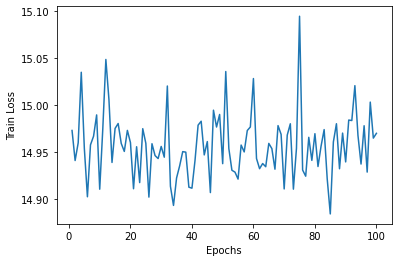

In [28]:
plt.figure()
plt.plot(range(1, n_epochs+1), train_loss_list, label = 'Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')

In [29]:
# Evaluate PyTorch model on test set
test_dataset = FreeSolvDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

with torch.no_grad():
    model.eval()
    test_loss = 0
    for fingerprints,energies in test_loader:
        outputs = model(fingerprints)
        test_loss += criterion(outputs, energies).item()*len(energies)
    test_loss /= len(test_dataset)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 14.7120


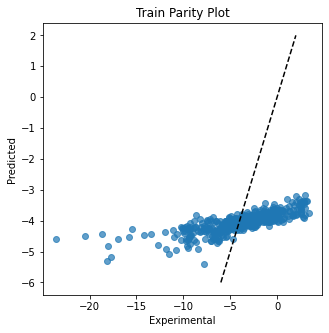

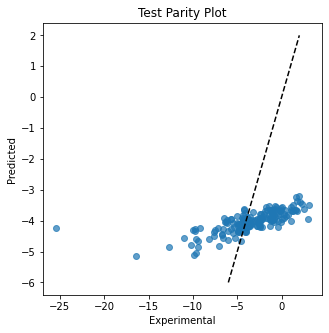

In [30]:
# Predict solvation free energies for train
train_pred = model(torch.Tensor(X_train)).detach().numpy()
# Predict solvation free energies for test
test_pred = model(torch.Tensor(X_test)).detach().numpy()

# Plot parity plot for training set
plt.figure(figsize=(5,5))
plt.scatter(y_train, train_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Train Parity Plot')
plt.show()

# Plot parity plot for testing set
plt.figure(figsize=(5,5))
plt.scatter(y_test, test_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Test Parity Plot')
plt.show()

In [31]:
# train data metrics
train_mse = sklearn.metrics.mean_squared_error(y_train, train_pred)
train_mae = sklearn.metrics.mean_absolute_error(y_train, train_pred)
train_r2 = sklearn.metrics.r2_score(y_train, train_pred)
print(f'Train MSE: {train_mse} Train MAE: {train_mae} Train R2 Score: {train_r2}')

# test data metrics
test_mse = sklearn.metrics.mean_squared_error(y_test, test_pred)
test_mae = sklearn.metrics.mean_absolute_error(y_test, test_pred)
test_r2 = sklearn.metrics.r2_score(y_test, test_pred)
print(f'Test MSE: {test_mse} Test MAE: {test_mae} Test R2 Score: {test_r2}')

Train MSE: 13.119332253824668 Train MAE: 2.6643419139647926 Train R2 Score: 0.11942590122495067
Test MSE: 12.749960426293859 Test MAE: 2.6515808404010275 Test R2 Score: 0.10054733990234521


Comparing the test metrices on ReLU and sigmoid we got ReLU activation better the sigmoid for this problem statement therefore we will use ReLU in our next part

# 3c

5 layers Neural Network with ReLU as activation function

In [32]:
# Define a PyTorch model using ReLU with 5 layers
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc5 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [33]:
# Train the PyTorch model
n_epochs = 100
train_dataset = FreeSolvDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

model = Net(input_size = 2048, hidden_size = 128, output_size = 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [35]:
train_loss_list = []
y_pred_train_list = []
for epoch in range(n_epochs):
    train_loss = 0
    epoch_size = 0
    for fingerprints,energies in train_loader:
        optimizer.zero_grad()
        outputs = model(fingerprints)
        y_pred_train_list.append(outputs)
        loss = criterion(outputs, energies)
        train_loss += loss.item()*len(energies)
        epoch_size += len(energies)
        loss.backward()
        optimizer.step()
    train_loss /= epoch_size
    train_loss_list.append(train_loss)
    if (epoch+1)%10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, train_loss))

Epoch [10/100], Loss: 15.2047
Epoch [20/100], Loss: 15.0156
Epoch [30/100], Loss: 15.0054
Epoch [40/100], Loss: 15.0481
Epoch [50/100], Loss: 15.1727
Epoch [60/100], Loss: 14.9796
Epoch [70/100], Loss: 14.9941
Epoch [80/100], Loss: 15.0129
Epoch [90/100], Loss: 14.9576
Epoch [100/100], Loss: 14.9459


Text(0, 0.5, 'Train Loss')

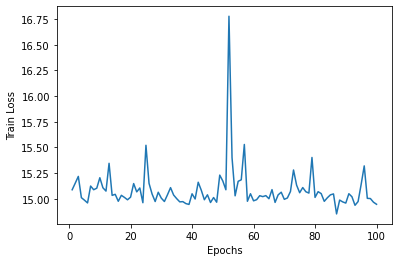

In [36]:
plt.figure()
plt.plot(range(1, n_epochs+1), train_loss_list, label = 'Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')

In [37]:
# Evaluate PyTorch model on test set
test_dataset = FreeSolvDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

with torch.no_grad():
    model.eval()
    test_loss = 0
    for fingerprints,energies in test_loader:
        outputs = model(fingerprints)
        test_loss += criterion(outputs, energies).item()*len(energies)
    test_loss /= len(test_dataset)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 14.3842


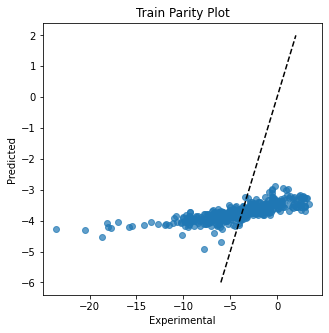

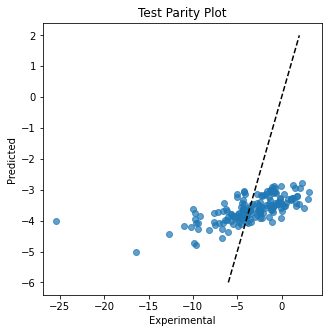

In [38]:
# Predict solvation free energies for train
train_pred = model(torch.Tensor(X_train)).detach().numpy()
# Predict solvation free energies for test
test_pred = model(torch.Tensor(X_test)).detach().numpy()

# Plot parity plot for training set
plt.figure(figsize=(5,5))
plt.scatter(y_train, train_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Train Parity Plot')
plt.show()

# Plot parity plot for testing set
plt.figure(figsize=(5,5))
plt.scatter(y_test, test_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Test Parity Plot')
plt.show()

In [39]:
# train data metrics
train_mse = sklearn.metrics.mean_squared_error(y_train, train_pred)
train_mae = sklearn.metrics.mean_absolute_error(y_train, train_pred)
train_r2 = sklearn.metrics.r2_score(y_train, train_pred)
print(f'Train MSE: {train_mse} Train MAE: {train_mae} Train R2 Score: {train_r2}')

# test data metrics
test_mse = sklearn.metrics.mean_squared_error(y_test, test_pred)
test_mae = sklearn.metrics.mean_absolute_error(y_test, test_pred)
test_r2 = sklearn.metrics.r2_score(y_test, test_pred)
print(f'Test MSE: {test_mse} Test MAE: {test_mae} Test R2 Score: {test_r2}')

Train MSE: 13.455433124613634 Train MAE: 2.6664647097200964 Train R2 Score: 0.0968666950346948
Test MSE: 12.36657419914756 Test MAE: 2.5703903701142496 Test R2 Score: 0.12759352281757952


9 layers Neural Network with ReLU as activation function

In [40]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc5 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc6 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc7 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc8 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc9 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.relu(self.fc4(x))
        x = torch.nn.functional.relu(self.fc5(x))
        x = torch.nn.functional.relu(self.fc6(x))
        x = torch.nn.functional.relu(self.fc7(x))
        x = torch.nn.functional.relu(self.fc8(x))
        x = self.fc9(x)
        return x

In [41]:
# Train the PyTorch model
n_epochs = 100
train_dataset = FreeSolvDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

model = Net(input_size = 2048, hidden_size = 128, output_size = 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [43]:
train_loss_list = []
y_pred_train_list = []
for epoch in range(n_epochs):
    train_loss = 0
    epoch_size = 0
    for fingerprints,energies in train_loader:
        optimizer.zero_grad()
        outputs = model(fingerprints)
        y_pred_train_list.append(outputs)
        loss = criterion(outputs, energies)
        train_loss += loss.item()*len(energies)
        epoch_size += len(energies)
        loss.backward()
        optimizer.step()
    train_loss /= epoch_size
    train_loss_list.append(train_loss)
    if (epoch+1)%10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, train_loss))

Epoch [10/100], Loss: 14.9414
Epoch [20/100], Loss: 14.8931
Epoch [30/100], Loss: 14.8956
Epoch [40/100], Loss: 14.9542
Epoch [50/100], Loss: 14.9055
Epoch [60/100], Loss: 15.0322
Epoch [70/100], Loss: 15.3789
Epoch [80/100], Loss: 14.9155
Epoch [90/100], Loss: 15.0181
Epoch [100/100], Loss: 14.9184


Text(0, 0.5, 'Train Loss')

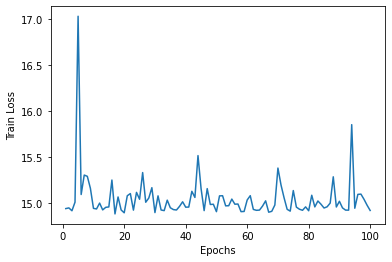

In [44]:
plt.figure()
plt.plot(range(1, n_epochs+1), train_loss_list, label = 'Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')

In [45]:
# Evaluate PyTorch model on test set
test_dataset = FreeSolvDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

with torch.no_grad():
    model.eval()
    test_loss = 0
    for fingerprints,energies in test_loader:
        outputs = model(fingerprints)
        test_loss += criterion(outputs, energies).item()*len(energies)
    test_loss /= len(test_dataset)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 14.5301


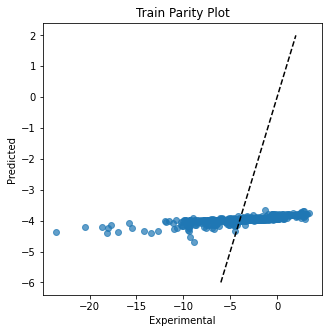

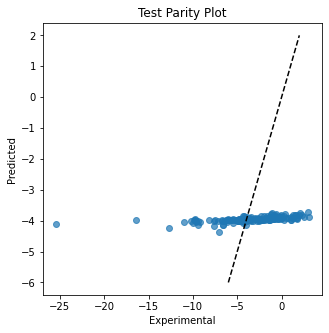

In [46]:
# Predict solvation free energies for train
train_pred = model(torch.Tensor(X_train)).detach().numpy()
# Predict solvation free energies for test
test_pred = model(torch.Tensor(X_test)).detach().numpy()

# Plot parity plot for training set
plt.figure(figsize=(5,5))
plt.scatter(y_train, train_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Train Parity Plot')
plt.show()

# Plot parity plot for testing set
plt.figure(figsize=(5,5))
plt.scatter(y_test, test_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Test Parity Plot')
plt.show()

In [47]:
# train data metrics
train_mse = sklearn.metrics.mean_squared_error(y_train, train_pred)
train_mae = sklearn.metrics.mean_absolute_error(y_train, train_pred)
train_r2 = sklearn.metrics.r2_score(y_train, train_pred)
print(f'Train MSE: {train_mse} Train MAE: {train_mae} Train R2 Score: {train_r2}')

# test data metrics
test_mse = sklearn.metrics.mean_squared_error(y_test, test_pred)
test_mae = sklearn.metrics.mean_absolute_error(y_test, test_pred)
test_r2 = sklearn.metrics.r2_score(y_test, test_pred)
print(f'Test MSE: {test_mse} Test MAE: {test_mae} Test R2 Score: {test_r2}')

Train MSE: 14.238080583211541 Train MAE: 2.789388583454917 Train R2 Score: 0.04433512809366258
Test MSE: 14.113201664455774 Test MAE: 2.7987062262304083 Test R2 Score: 0.004376770188978973


Comparing test metrices on 5 layer and 9 layer neural network we analyze that 5 layer neural network is better the 9 layer neural network because 9 layer neural network overfits the train data and thus does not performs good on test data. So in ou next part we will use 5 layer neural network with ReLU as our activation function

# 3d

Changing number of neurons to 64 in every hidden layer

In [48]:
# Define a PyTorch model using ReLU with 5 layers
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc5 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [49]:
# Train the PyTorch model
n_epochs = 100
train_dataset = FreeSolvDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

model = Net(input_size = 2048, hidden_size = 64, output_size = 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [51]:
train_loss_list = []
y_pred_train_list = []
for epoch in range(n_epochs):
    train_loss = 0
    epoch_size = 0
    for fingerprints,energies in train_loader:
        optimizer.zero_grad()
        outputs = model(fingerprints)
        y_pred_train_list.append(outputs)
        loss = criterion(outputs, energies)
        train_loss += loss.item()*len(energies)
        epoch_size += len(energies)
        loss.backward()
        optimizer.step()
    train_loss /= epoch_size
    train_loss_list.append(train_loss)
    if (epoch+1)%10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, train_loss))

Epoch [10/100], Loss: 14.9571
Epoch [20/100], Loss: 14.9507
Epoch [30/100], Loss: 15.0074
Epoch [40/100], Loss: 14.9512
Epoch [50/100], Loss: 15.0796
Epoch [60/100], Loss: 14.9731
Epoch [70/100], Loss: 15.0026
Epoch [80/100], Loss: 14.9540
Epoch [90/100], Loss: 15.2183
Epoch [100/100], Loss: 14.9506


Text(0, 0.5, 'Train Loss')

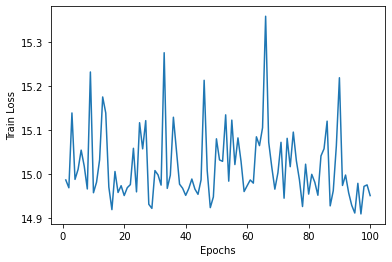

In [52]:
plt.figure()
plt.plot(range(1, n_epochs+1), train_loss_list, label = 'Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')

In [53]:
# Evaluate PyTorch model on test set
test_dataset = FreeSolvDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

with torch.no_grad():
    model.eval()
    test_loss = 0
    for fingerprints,energies in test_loader:
        outputs = model(fingerprints)
        test_loss += criterion(outputs, energies).item()*len(energies)
    test_loss /= len(test_dataset)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 14.4773


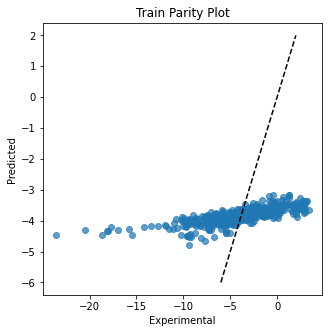

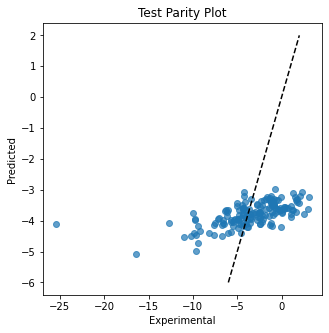

In [54]:
# Predict solvation free energies for train
train_pred = model(torch.Tensor(X_train)).detach().numpy()
# Predict solvation free energies for test
test_pred = model(torch.Tensor(X_test)).detach().numpy()

# Plot parity plot for training set
plt.figure(figsize=(5,5))
plt.scatter(y_train, train_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Train Parity Plot')
plt.show()

# Plot parity plot for testing set
plt.figure(figsize=(5,5))
plt.scatter(y_test, test_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Test Parity Plot')
plt.show()

In [55]:
# train data metrics
train_mse = sklearn.metrics.mean_squared_error(y_train, train_pred)
train_mae = sklearn.metrics.mean_absolute_error(y_train, train_pred)
train_r2 = sklearn.metrics.r2_score(y_train, train_pred)
print(f'Train MSE: {train_mse} Train MAE: {train_mae} Train R2 Score: {train_r2}')

# test data metrics
test_mse = sklearn.metrics.mean_squared_error(y_test, test_pred)
test_mae = sklearn.metrics.mean_absolute_error(y_test, test_pred)
test_r2 = sklearn.metrics.r2_score(y_test, test_pred)
print(f'Test MSE: {test_mse} Test MAE: {test_mae} Test R2 Score: {test_r2}')

Train MSE: 13.490584684521778 Train MAE: 2.683585845566589 Train R2 Score: 0.09450731022853398
Test MSE: 12.716756077044941 Test MAE: 2.634408534387624 Test R2 Score: 0.10288975817347645


Changing number of neurons to 256 in every hidden layer

In [56]:
# Train the PyTorch model
n_epochs = 100
train_dataset = FreeSolvDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

model = Net(input_size = 2048, hidden_size = 256, output_size = 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [58]:
train_loss_list = []
y_pred_train_list = []
for epoch in range(n_epochs):
    train_loss = 0
    epoch_size = 0
    for fingerprints,energies in train_loader:
        optimizer.zero_grad()
        outputs = model(fingerprints)
        y_pred_train_list.append(outputs)
        loss = criterion(outputs, energies)
        train_loss += loss.item()*len(energies)
        epoch_size += len(energies)
        loss.backward()
        optimizer.step()
    train_loss /= epoch_size
    train_loss_list.append(train_loss)
    if (epoch+1)%10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, train_loss))

Epoch [10/100], Loss: 14.9992
Epoch [20/100], Loss: 15.3136
Epoch [30/100], Loss: 15.0063
Epoch [40/100], Loss: 14.9260
Epoch [50/100], Loss: 14.9936
Epoch [60/100], Loss: 14.9156
Epoch [70/100], Loss: 14.9307
Epoch [80/100], Loss: 14.9230
Epoch [90/100], Loss: 14.9764
Epoch [100/100], Loss: 15.0376


Text(0, 0.5, 'Train Loss')

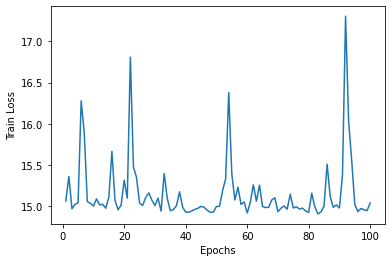

In [59]:
plt.figure()
plt.plot(range(1, n_epochs+1), train_loss_list, label = 'Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')

In [60]:
# Evaluate PyTorch model on test set
test_dataset = FreeSolvDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

with torch.no_grad():
    model.eval()
    test_loss = 0
    for fingerprints,energies in test_loader:
        outputs = model(fingerprints)
        test_loss += criterion(outputs, energies).item()*len(energies)
    test_loss /= len(test_dataset)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 14.5890


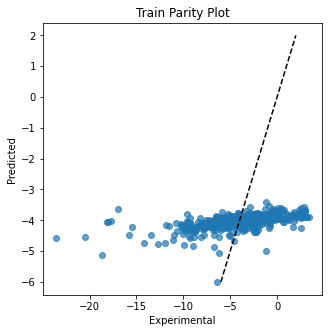

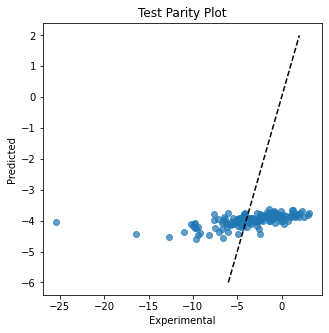

In [61]:
# Predict solvation free energies for train
train_pred = model(torch.Tensor(X_train)).detach().numpy()
# Predict solvation free energies for test
test_pred = model(torch.Tensor(X_test)).detach().numpy()

# Plot parity plot for training set
plt.figure(figsize=(5,5))
plt.scatter(y_train, train_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Train Parity Plot')
plt.show()

# Plot parity plot for testing set
plt.figure(figsize=(5,5))
plt.scatter(y_test, test_pred, alpha = 0.7)
plt.plot([-6,2], [-6,2], color='black', linestyle='--')
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Test Parity Plot')
plt.show()

In [62]:
# train data metrics
train_mse = sklearn.metrics.mean_squared_error(y_train, train_pred)
train_mae = sklearn.metrics.mean_absolute_error(y_train, train_pred)
train_r2 = sklearn.metrics.r2_score(y_train, train_pred)
print(f'Train MSE: {train_mse} Train MAE: {train_mae} Train R2 Score: {train_r2}')

# test data metrics
test_mse = sklearn.metrics.mean_squared_error(y_test, test_pred)
test_mae = sklearn.metrics.mean_absolute_error(y_test, test_pred)
test_r2 = sklearn.metrics.r2_score(y_test, test_pred)
print(f'Test MSE: {test_mse} Test MAE: {test_mae} Test R2 Score: {test_r2}')

Train MSE: 13.925231337059737 Train MAE: 2.7525583636587228 Train R2 Score: 0.06533367723112082
Test MSE: 13.671099650016957 Test MAE: 2.7470108129963373 Test R2 Score: 0.03556508918183343


By seeing the test metrices of 64 and 256 neurons in each hidden layer we conclude that 64 neurons per hidden layer perfoms better then 256 neurons per hidden layer